In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from paraspec.base import IR12SpeciationModel

%matplotlib inline

# Run the model in a static landscape

In [2]:
length = (250, 250)
spacing = (1, 1)

X, Y = np.meshgrid(*[np.arange(0, l+s, s)
                     for l, s in zip(length, spacing)])

r = np.random.RandomState(0)

elevation = X * 10 + r.rand(*Y.shape)

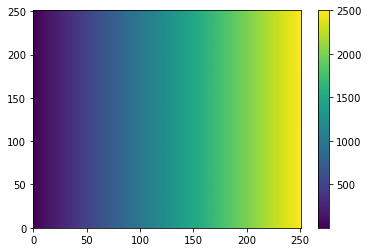

In [3]:
plt.pcolormesh(elevation)
plt.colorbar();

## Speciation model without competition

In [4]:
pop_size = 100
num_gen = 1000
plot_gen_by = np.arange(0, num_gen, 100)
dt = 1

model1 = IR12SpeciationModel(X, Y, pop_size,
                             nb_radius=50, capacity=50,
                             sigma_w=0.2, sigma_d=5, sigma_mut=0.05,
                             lifespan=1, m_freq=0.05, random_seed=1234)

#model1.initialize([elevation.mean(), elevation.mean()])
model1.initialize([0.5, 0.5])

dfs1 = []

for step in range(num_gen):
    model1.evaluate_fitness(elevation, dt)

    dfs1.append(model1.to_dataframe())
    
    model1.update_population(dt)
    
population1 = pd.concat(dfs1)

In [5]:
population1

,step,time,dt,id,parent,x,y,trait,r_d,opt_trait,fitness,n_offspring
0,0,0.0,0.0,0,0,244.174942,74.460023,0.500000,5.555556,0.952197,0.077612,0
1,0,0.0,0.0,1,1,95.048934,154.790254,0.500000,3.571429,0.386204,0.850552,3
2,0,0.0,0.0,2,2,230.811558,75.439357,0.500000,5.555556,0.902622,0.131821,1
3,0,0.0,0.0,3,3,65.423106,43.711613,0.500000,4.545455,0.272106,0.522465,2
4,0,0.0,0.0,4,4,79.774265,123.876299,0.500000,5.555556,0.329254,0.694595,4
...,...,...,...,...,...,...,...,...,...,...,...,...
475,999,999.0,0.0,472835,472355,13.171504,156.815113,0.110436,1.315789,0.074674,0.984141,1
476,999,999.0,0.0,472836,472356,7.188479,171.159810,0.203223,1.282051,0.051961,0.751261,1
477,999,999.0,0.0,472837,472357,20.123952,158.201718,0.283555,1.190476,0.100999,0.659297,1
478,999,999.0,0.0,472838,472358,12.161057,191.500115,-0.150019,0.925926,0.070740,0.543797,1


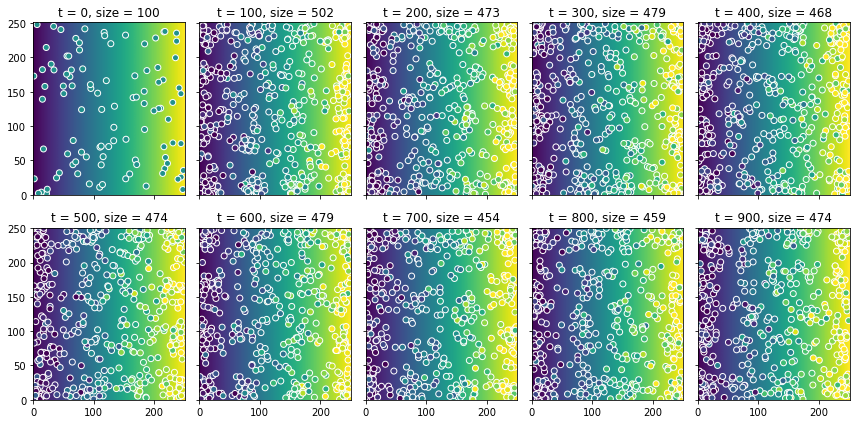

In [6]:
fig1, axes1 = plt.subplots(nrows=2, ncols=5, sharex='col', sharey='row',figsize=(12, 6))
for ax, print_step in zip(axes1.ravel(), plot_gen_by):
    pop = population1.groupby('step').get_group(print_step)
    ax.pcolormesh(elevation)
    ax.scatter(pop.x, pop.y, c=pop.trait, edgecolor='w',vmin=0, vmax=1)#vmin=elevation.min(), vmax=elevation.max())
    ax.set_title(f't = {print_step}, size = {len(pop)}')
fig1.tight_layout()

Text(0.5, 0, 'Time (generations)')

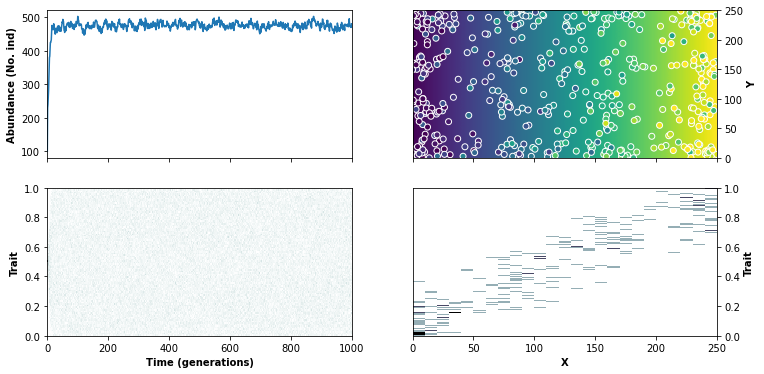

In [7]:
fig2, axs2 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
axs2[0,0].plot(population1.groupby('step').size())
h,xedge,yedge,_=axs2[1,0].hist2d(x=population1['step'], y=population1['trait'], 
                                 range=((0, num_gen), (0, 1)), #(0, elevation.max())), 
                                 bins=(num_gen, 100), cmap='bone_r')
axs2[0, 1].pcolormesh(elevation)
axs2[0, 1].scatter(population1['x'].loc[population1['step']==max(population1['step'])], 
                   population1['y'].loc[population1['step']==max(population1['step'])], 
                   c=population1['trait'].loc[population1['step']==max(population1['step'])], 
                   #edgecolor='w',vmin=elevation.min(), vmax=elevation.max())
                   edgecolor='w',vmin=0, vmax=1)
h,xedge,yedge,_=axs2[1,1].hist2d(x=population1['x'].loc[population1['step']==max(population1['step'])], 
                                 y=population1['trait'].loc[population1['step']==max(population1['step'])], 
                                 range=((0, X.max()), (0, 1)), #(0, elevation.max())), 
                                 bins=(25, 250), cmap='bone_r')
axs2[0, 1].yaxis.set_label_position("right")
axs2[0, 1].yaxis.tick_right()
axs2[1, 1].yaxis.set_label_position("right")
axs2[1, 1].yaxis.tick_right()
axs2[0, 1].set_ylabel('Y', weight='bold')
axs2[0, 0].set_ylabel('Abundance (No. ind)', weight='bold')
axs2[1, 1].set_ylabel('Trait', weight='bold')
axs2[1, 0].set_ylabel('Trait', weight='bold')
axs2[1, 1].set_xlabel('X', weight='bold')
axs2[1, 0].set_xlabel('Time (generations)', weight='bold')

## Speciation model with competition

In [8]:
from paraspec.base import DD03SpeciationModel

In [9]:
model2 = DD03SpeciationModel(X, Y, pop_size, car_cap_max=500, sigma_opt_trait=0.2, mut_prob=0.05, sigma_mut=0.05,
                 sigma_mov=5, sigma_comp_trait=0.9, sigma_comp_dist=0.1, random_seed=1234)

model2.initialize([0.5, 0.5])

dfs2 = []
dfs2.append(model2.to_dataframe())
for step in range(num_gen):
    model2.update(elevation)
    dfs2.append(model2.to_dataframe())
    
population2 = pd.concat(dfs2)

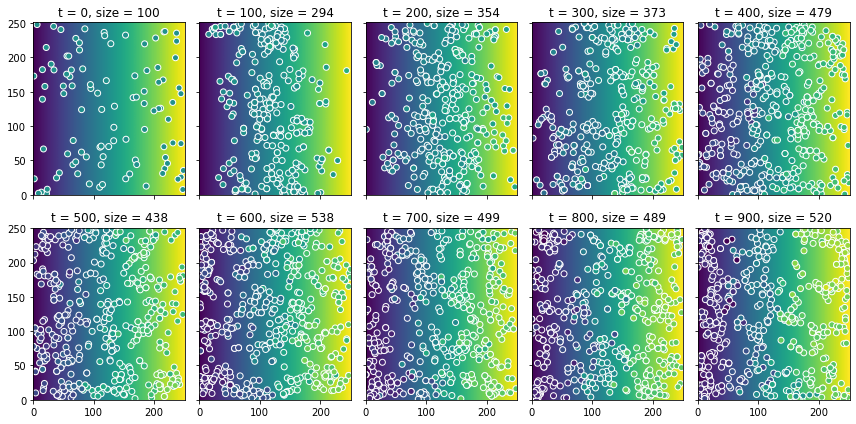

In [10]:
fig3, axes3 = plt.subplots(nrows=2, ncols=5, sharex='col', sharey='row',figsize=(12, 6))
for ax, print_step in zip(axes3.ravel(), plot_gen_by):
    pop = population2.groupby('step').get_group(print_step)
    ax.pcolormesh(elevation)
    ax.scatter(pop.x, pop.y, c=pop.trait, edgecolor='w',vmin=0, vmax=1)
    ax.set_title(f't = {print_step}, size = {len(pop)}')
fig3.tight_layout()

Text(0.5, 0, 'Time (generations)')

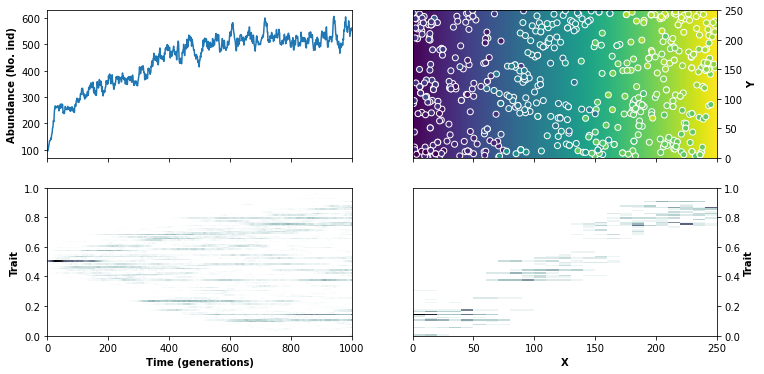

In [11]:
fig4, axs4 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
axs4[0,0].plot(population2.groupby('step').size())
h,xedge,yedge,_=axs4[1,0].hist2d(x=population2['step'], y=population2['trait'], 
                               range=((0, num_gen), (0, 1)), bins=(num_gen, 100), cmap='bone_r')
axs4[0, 1].pcolormesh(elevation)
axs4[0, 1].scatter(population2['x'].loc[population2['step']==max(population2['step'])], 
                      population2['y'].loc[population2['step']==max(population2['step'])], 
                      c=population2['trait'].loc[population2['step']==max(population2['step'])], 
                      edgecolor='w',vmin=0, vmax=1)
h,xedge,yedge,_=axs4[1,1].hist2d(x=population2['x'].loc[population2['step']==max(population2['step'])], 
                                 y=population2['trait'].loc[population2['step']==max(population2['step'])], 
                               range=((0, X.max()), (0, 1)), bins=(25, 100), cmap='bone_r')
axs4[0, 1].yaxis.set_label_position("right")
axs4[0, 1].yaxis.tick_right()
axs4[1, 1].yaxis.set_label_position("right")
axs4[1, 1].yaxis.tick_right()
axs4[0, 1].set_ylabel('Y', weight='bold')
axs4[0, 0].set_ylabel('Abundance (No. ind)', weight='bold')
axs4[1, 1].set_ylabel('Trait', weight='bold')
axs4[1, 0].set_ylabel('Trait', weight='bold')
axs4[1, 1].set_xlabel('X', weight='bold')
axs4[1, 0].set_xlabel('Time (generations)', weight='bold')